# ArcFace Loss (Additive Angular Margin Loss)

### Импорт библиотек, начальные установки, загрузка метаданных датасета

In [279]:
import os
import pickle


import shutil
import random
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import gc

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# все пути указаны относительны папки текущего проекта
dir_dataset = 'data_CelebA_mini'  # папка для уменьшенного датасета
dir_aligned = f'{dir_dataset}/data_aligned'  # папка для выровненных изображений уменьшенного датасета

base_dir = f'{dir_dataset}/data_fr' # папка для формирования датасета для распознавания лиц (физическое разделение изображений)
ident_dir = f'{dir_dataset}/data_IRM' # папка для реализации Identification Rate Metric
dir_metadata_fr = f'{dir_dataset}/metadata_fr' # папка для метаданных для распознавания лиц


# файл метаданных
metadata_aligned = f'{dir_dataset}/list_attr_celeba_mini.csv'


# папки для обучения
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'
# папки для identification rate
query_dir = f'{ident_dir}/query'
distractors_dir = f'{ident_dir}/distractors'


dir_checkpoints = 'checkpoints' # папка для сохранения чекпоинтов


# создаем все необходимые папки
dirs_to_create = [train_dir, val_dir, test_dir, query_dir, distractors_dir, dir_metadata_fr, dir_checkpoints]
for dir_path in dirs_to_create:
    os.makedirs(dir_path, exist_ok=True)




# параметры изображений
IMAGE_SIZE = (112, 112)        # Размер изображений для обучения
HEATMAP_SIZE = (28, 28)        # Размер heatmaps
SCALE = 0.9                    # Масштабирование bbox

# параметры обучения
BATCH_SIZE = 64                # Размер батча
NUM_EPOCHS = 20                # Количество эпох
LEARNING_RATE = 1e-4           # Базовый learning rate

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {DEVICE}")

# проверяем папку выровненных изображений
if not os.path.exists(dir_aligned):
    print(f"Папка с выровненными изображениями не найдена: {dir_aligned}")
    raise FileNotFoundError("Aligned images directory not found")

# подсчет количества изображений
aligned_images = [f for f in os.listdir(dir_aligned) if f.endswith(('.jpg', '.png'))]
print(f"Найдено выровненных изображений: {len(aligned_images)}")

if len(aligned_images) == 0:
    print("В папке нет изображений! Проверьте процесс выравнивания из предыдущего этапа")
    raise ValueError("No aligned images found")


# устанавливаем ядра рандомов
RANDOM_SEED = 4242
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

Используемое устройство: cuda
Найдено выровненных изображений: 11000


In [102]:
# загружаем метаданные датасета
try:
    df = pd.read_csv(metadata_aligned)
    print(f"Загружено {len(df)} записей из {metadata_aligned}")
except Exception as e:
    print(f"Ошибка при загрузке файла: {e}")
    raise

# проверяем наличие ключевых колонок
required_columns = ['image_id', 'person_id']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Отсутствуют необходимые колонки: {missing_columns}")
    print("Доступные колонки:", df.columns.tolist())
    raise ValueError("Отсутствуют необходимые колонки в метаданных")

# проверяем распределение по персонам
person_counts = df['person_id'].value_counts()
print(f"\nРаспределение изображений по персонам:")
print(f"Всего уникальных персон: {len(person_counts)}")
print(f"Минимальное количество изображений на персону: {person_counts.min()}")
print(f"Максимальное количество изображений на персону: {person_counts.max()}")
print(f"Среднее количество изображений на персону: {person_counts.mean():.1f}")

if person_counts.min() == person_counts.max():
    print(f'Все персоны имеют равное количество изображений, {person_counts.min()} - это отлично для балансировки!')

# проверяем наличие файлов изображений
print(f"\nПроверка файлов изображений:")
missing_files = 0
for img_id in tqdm(df['image_id'], desc="Проверка файлов"):
    img_path = os.path.join(dir_aligned, img_id)
    if not os.path.exists(img_path):
        missing_files += 1

if missing_files > 0:
    print(f"Отсутствует файлов: {missing_files} из {len(df)}")
else:
    print("Все файлы изображений найдены")

Загружено 11000 записей из data_CelebA_mini/list_attr_celeba_mini.csv

Распределение изображений по персонам:
Всего уникальных персон: 550
Минимальное количество изображений на персону: 20
Максимальное количество изображений на персону: 20
Среднее количество изображений на персону: 20.0
Все персоны имеют равное количество изображений, 20 - это отлично для балансировки!

Проверка файлов изображений:


Проверка файлов: 100%|██████████| 11000/11000 [00:00<00:00, 228914.92it/s]

Все файлы изображений найдены


### Формирование наборов (выборок) изображений

In [103]:
# список всех персон
all_persons = np.sort(df['person_id'].unique()).tolist()
# группируем изображения по персонам
person_groups = df.groupby('person_id')['image_id'].apply(list).to_dict()

# пропорции разделения
# сначала выделяем персоны для Identification Rate Metric
ident_ratio = 0.2  # 20% персон для identification rate
# оставшиеся персоны разделяем так:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# разбивка датасета на части для Identification Rate Metric
query_ratio = 0.3  # 30% от ident_ratio для query
distractors_ratio = 0.7  # 70% от ident_ratio для distractors


assert train_ratio > 0 and val_ratio > 0 and test_ratio > 0, "Пропорции должны быть положительными"
assert train_ratio > val_ratio and train_ratio > test_ratio, "Тренировочная часть должна быть больше других"
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Сумма пропорций должна быть равна 1"
assert abs(query_ratio + distractors_ratio - 1.0) < 1e-6, "Сумма пропорций для Identification Rate Metric должна быть равна 1"

# рассчитываем количество персон для каждого набора
num_ident_persons = int(len(all_persons) * ident_ratio)
num_train_persons = len(all_persons) - num_ident_persons

random.shuffle(all_persons) # перемешиваем список персон

# делим весь датасет на тренировочную и оценочную части
ident_persons = all_persons[:num_ident_persons]
train_persons = all_persons[num_ident_persons:]

# рассчитываем количество персон для наборов Identification Rate Metric
num_query_persons = int(len(ident_persons) * query_ratio)
num_distractors_persons = len(ident_persons) - num_query_persons
# формируем списки наборов для IRM
query_persons = ident_persons[:num_query_persons]
distractors_persons = ident_persons[num_query_persons:]

print(f"Всего персон: {len(all_persons)}")
print(f"Для обучения: {len(train_persons)} персон")

# из тренировочной части формируем списки для train/val/test наборов изображений
train_data, val_data, test_data = [], [], []
query_data, distractors_data = [], []  # наборы для будущей реализации identification rate


# группируем изображения по персонам из обучающей части
train_df = df[df['person_id'].isin(train_persons)].copy()
person_groups = train_df.groupby('person_id')['image_id'].apply(list).to_dict()

# разделение осуществляем по каждой персоне для баланса
for person_id, images in tqdm(person_groups.items(), desc="Сбалансированное разделение на train/val/test по персонам"):
    # перемешиваем изображения
    random.shuffle(images)
    
    # количество изображений в каждом наборе
    n = len(images)
    if n == 0:
        continue
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val
    if n_test < 1:
        n_train -= 1
        n_test = 1
    assert n_train + n_val + n_test == n, f"Сумма изображений в наборах должна быть равна {n}"
    
    # разделяем изображения по наборам
    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]
    
    # формируем соответствующие списки наборов изображений с метками классов
    train_data.extend([{'image_id': img, 'person_id': person_id} for img in train_imgs])
    val_data.extend([{'image_id': img, 'person_id': person_id} for img in val_imgs])
    test_data.extend([{'image_id': img, 'person_id': person_id} for img in test_imgs])    


# теперь выделим изображения для Identification Rate Metric

# группируем изображения по персонам из identification rate части
ident_df = df[df['person_id'].isin(ident_persons)].copy()
ident_person_group = ident_df.groupby('person_id')['image_id'].apply(list).to_dict()

# QUERY SET по 2 изображения на человека
for person_id in tqdm(query_persons, desc="Создание query set"):
    images = ident_person_group[person_id]
    if len(images) >= 2:  # минимум 2 изображения для positive pairs
        query_data.append({'image_id': images[0], 'person_id': person_id})
        query_data.append({'image_id': images[1], 'person_id': person_id})

# DISTRACTORS SET по 1 изображению на человека
for person_id in tqdm(distractors_persons, desc="Создание distractors set"):
    images = ident_person_group[person_id]
    if images:  # Если есть изображения
        distractors_data.append({'image_id': images[0], 'person_id': person_id})

print(f"Для identification rate: {len(ident_persons)} персон")
print(f"Query set: {len(query_data)} изображений от {len(query_persons)} персон")
print(f"Distractors set: {len(distractors_data)} изображений от {len(distractors_persons)} персон")

Всего персон: 550
Для обучения: 440 персон


Сбалансированное разделение на train/val/test по персонам: 100%|██████████| 440/440 [00:00<00:00, 49437.28it/s]
Создание distractors set: 100%|██████████| 77/77 [00:00<00:00, 371647.19it/s]

Для identification rate: 110 персон
Query set: 66 изображений от 33 персон
Distractors set: 77 изображений от 77 персон


In [105]:
# создаем маппинг person_id -> class_id ТОЛЬКО для обучающих персон
person_to_class = {person_id: idx for idx, person_id in enumerate(sorted(train_persons))}

# теперь надо добавить class_id в каждый набор данных
train_data = [{**item, 'class_id': person_to_class[item['person_id']]} for item in train_data]
val_data = [{**item, 'class_id': person_to_class[item['person_id']]} for item in val_data]
test_data = [{**item, 'class_id': person_to_class[item['person_id']]} for item in test_data]

print("Результаты разделения:")
print(f"Train: {len(train_data)} изображений, {len(set([item['class_id'] for item in train_data]))} классов")
print(f"Val:   {len(val_data)} изображений, {len(set([item['class_id'] for item in val_data]))} классов")
print(f"Test:  {len(test_data)} изображений, {len(set([item['class_id'] for item in test_data]))} классов")

Результаты разделения:
Train: 6160 изображений, 440 классов
Val:   1320 изображений, 440 классов
Test:  1320 изображений, 440 классов


In [ ]:
# cохраняем метаданные
pd.DataFrame(train_data).to_csv(f'{dir_metadata_fr}/train_metadata.csv', index=False)
pd.DataFrame(val_data).to_csv(f'{dir_metadata_fr}/val_metadata.csv', index=False)
pd.DataFrame(test_data).to_csv(f'{dir_metadata_fr}/test_metadata.csv', index=False)
# Сохраняем данные для identification rate
pd.DataFrame(query_data).to_csv(f'{dir_metadata_fr}/query_metadata.csv', index=False)
pd.DataFrame(distractors_data).to_csv(f'{dir_metadata_fr}/distractors_metadata.csv', index=False)


def copy_images(data_list, source_dir, dest_dir, desc):
    """
    Копирует изображения из source_dir в dest_dir на основе списка данных
    
    Args:
        data_list: список словарей с ключом 'image_id'
        source_dir: исходная папка с изображениями
        dest_dir: целевая папка для копирования
        desc: описание для tqdm
    """
    copied = 0
    skipped = 0
    
    for item in tqdm(data_list, desc=desc):
        src_path = os.path.join(source_dir, item['image_id'])
        dest_path = os.path.join(dest_dir, item['image_id'])
        
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)
            copied += 1
        else:
            skipped += 1
            print(f"Файл не найден: {src_path}")
    
    return copied, skipped


# копируем изображения для обучения
train_copied, train_skipped = copy_images(train_data, dir_aligned, train_dir, "Train изображения")
val_copied, val_skipped = copy_images(val_data, dir_aligned, val_dir, "Val изображения")
test_copied, test_skipped = copy_images(test_data, dir_aligned, test_dir, "Test изображения")

# копируем изображения для identification rate
query_copied, query_skipped = copy_images(query_data, dir_aligned, query_dir, "Query изображения")
distractors_copied, distractors_skipped = copy_images(distractors_data, dir_aligned, distractors_dir, "Distractors изображения")

print(f"Train: скопировано {train_copied}, пропущено {train_skipped}")
print(f"Val: скопировано {val_copied}, пропущено {val_skipped}")
print(f"Test: скопировано {test_copied}, пропущено {test_skipped}")
print(f"Query: скопировано {query_copied}, пропущено {query_skipped}")
print(f"Distractors: скопировано {distractors_copied}, пропущено {distractors_skipped}")

Distractors изображения: 100%|██████████| 77/77 [00:00<00:00, 4131.21it/s]

Train: скопировано 6160, пропущено 0
Val: скопировано 1320, пропущено 0
Test: скопировано 1320, пропущено 0
Query: скопировано 66, пропущено 0
Distractors: скопировано 77, пропущено 0


### Загрузчик данных

Для загрузчиков будем использовать наследника класса Dataset, так как, хотя сложной обработки данных в отличие от обучения StackedHourglass здесь нет (нам не нужна сложная обработка изображений и метаданных), но все изображения всех персон (классов) лежат в куче по папкам train/val/test, а для класса ImageFolder нужна иерархическая структура - №_класса/*.jpg.

In [5]:
# трансформации
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # стандартный размер для ResNet
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class FRDataset(Dataset):
    """
    Датасет для распознавания лиц с использованием метаданных
    """
    def __init__(self, metadata_file, images_dir, transform=None):
        """
        Args:
            metadata_file: путь к CSV файлу с колонками ['image_id', 'person_id', 'class_id']
            images_dir: папка с изображениями
            transform: torchvision transforms
        """
        self.metadata = pd.read_csv(metadata_file)
        self.images_dir = images_dir
        self.transform = transform       
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.images_dir, row['image_id'])
        image = Image.open(img_path).convert('RGB') # загружаем изображение
        if self.transform: # если есть трансформации, то применяем их
            image = self.transform(image)
        # возвращаем изображение и метку класса
        return image, row['class_id']


# пути к метаданным
train_metadata = f'{dir_metadata_fr}/train_metadata.csv'
val_metadata = f'{dir_metadata_fr}/val_metadata.csv'
test_metadata = f'{dir_metadata_fr}/test_metadata.csv'


# создаем датасеты
train_dataset = FRDataset(
    metadata_file=train_metadata,
    images_dir=train_dir,
    transform=train_transform
)

val_dataset = FRDataset(
    metadata_file=val_metadata,
    images_dir=val_dir,
    transform=val_transform
)

test_dataset = FRDataset(
    metadata_file=test_metadata,
    images_dir=test_dir,
    transform=val_transform
)

num_classes = int(len(train_dataset.metadata['class_id'].unique()))

assert len(train_dataset.metadata['class_id'].unique()) == \
        len(val_dataset.metadata['class_id'].unique()) == \
        len(test_dataset.metadata['class_id'].unique()), \
        "Количество классов в разных наборах не совпадает!"


BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

### Модель ResNet18

Исходя из условия можно выбрать модели, обученные на ImageNet. Так как моя GPU довольно слабая - NVidia 2060 с 5.5 Гб, то можно использовать такие модели: ResNet18, EfficientNet-B0, MobileNetV2, ResNet50. Но исходя из того, что 

1) EfficientNet-B0 имеет сложную структуру, будет сложнее извлекать эмбендинги, они длиннее, чем у ResNet18;

2) MobileNetV2 очень компактная, но может не достичь требуемой точности по заданию (accuracy > 0.7);

3) ResNet50 слишком большая, для моей GPU близка к пределу, обучение будет медленным,

принимаем решение использовать ResNet18 (впрочем решение может быть пересмотрено по результатам обучения).

#### Функции обучения модели и визуализации прогресса обучения

In [176]:
# функции для обучения и валидации модели

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                device='cpu', num_epochs=1, start_epoch=0, 
                history=None,
                is_arcface=False, checkpoint_dir='checkpoints',
                model_name='model'):
    """
    Функция обучения и валидации модели
    
    Args:
        model: модель для обучения
        train_loader, val_loader: загрузчики данных
        criterion, optimizer, scheduler: компоненты обучения
        device: устройство для вычислений
        num_epochs: общее количество эпох
        start_epoch: начальная эпоха (для продолжения обучения)
        history: словарь с историей обучения для продолжения обучения
        is_arcface: флаг для ArcFace модели (требует передачи labels в forward)
        checkpoint_dir: папка для сохранения чекпоинтов
        model_name: имя модели для сохранения файлов
    
    Returns:
        Лучшая модель и обновленные списки истории
    """
    
    # инициализация лучших метрик
    if history is None:
        best_val_acc = 0.0
    else:
        best_val_acc = history['best_val_acc'] if 'best_val_acc' in history.keys() else 0.0
    
    best_model_path = None

    # журнал обучения
    if history is None:
        history = {
                'train_losses': [],
                'val_losses': [],
                'train_accs': [],
                'val_accs': [],
                'best_val_acc': best_val_acc,
                'current_lr': [],
                'is_arcface': is_arcface,
                'model_name': model_name
        }
    
    history['is_arcface'] = is_arcface
    history['model_name'] = model_name

    # папка для чекпоинтов
    os.makedirs(checkpoint_dir, exist_ok=True)
        
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f"Эпоха {epoch+1}/{start_epoch + num_epochs}"
        
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        batch_count = len(train_loader)
        
        # прогресс-бар для обучения
        train_pbar = tqdm(enumerate(train_loader), total=batch_count, 
                         desc=f"{epoch_str} | Обучение", 
                         bar_format='{l_bar}{bar:30}{r_bar}')
        
        for batch_idx, (images, labels) in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            if is_arcface:
                # особенность ArcFace: передаем labels в forward
                outputs, _ = model(images, labels)
            else:
                outputs = model(images)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # сбор метрик
            total_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            # обновляем прогресс-бар
            current_loss = loss.item()
            current_acc = (preds == labels).sum().item() / labels.size(0)
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}',
                'lr': f'{current_lr:.6f}'
            })
        
        train_loss = total_loss / batch_count
        train_acc = correct / total
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)        

        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        batch_count = len(val_loader)
        
        # прогресс-бар для валидации
        val_pbar = tqdm(enumerate(val_loader), total=batch_count,
                       desc=f"{epoch_str} | Валидация",
                       bar_format='{l_bar}{bar:30}{r_bar}')
        
        with torch.no_grad():
            for batch_idx, (images, labels) in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                if is_arcface:
                    embeddings = model(images)
                    # вычисляем логиты через косинусное сходство
                    weights = F.normalize(model.arcface.weight)
                    logits = F.linear(F.normalize(embeddings), weights) * model.arcface.s
                    outputs = logits
                else:
                    outputs = model(images)
                
                loss = criterion(outputs, labels)
                
                # сбор метрик
                total_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                # обновляем прогресс-бар
                current_loss = loss.item()
                current_acc = (preds == labels).sum().item() / labels.size(0)
                val_pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'acc': f'{current_acc:.4f}'
                })
        
        val_loss = total_loss / batch_count
        val_acc = correct / total
        history['val_losses'].append(val_loss)
        history['val_accs'].append(val_acc)
        
        history['best_val_acc'] = best_val_acc
        history['current_lr'].append(current_lr)


        # обновляем scheduler
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # сохраняем лучшую модель
        if (val_acc > best_val_acc) and (val_acc > 0.7):
            best_val_acc = val_acc
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            best_model_path = os.path.join(checkpoint_dir, f'{model_name}_{timestamp}_epoch_{epoch+1}_val_{best_val_acc:.4f}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss_history': history['train_losses'],
                'val_loss_history': history['val_losses'],
                'train_acc_history': history['train_accs'],
                'val_acc_history': history['val_accs'],
                'best_val_acc': best_val_acc,
                'best_epoch': epoch + 1,
                'current_lr': current_lr,
                'is_arcface': is_arcface,
                'num_classes': num_classes if 'num_classes' in locals() else None,
                'model_name': model_name
            }, best_model_path)
            print(f"Новая лучшая модель сохранена в {best_model_path}. Val Acc: {val_acc:.4f}")
            history['best_model_path'] = best_model_path
        
    # финальный чекпоинт
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_final_{timestamp}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss_history': history['train_losses'],
        'val_loss_history': history['val_losses'],
        'train_acc_history': history['train_accs'],
        'val_acc_history': history['val_accs'],
        'best_val_acc': best_val_acc,
        'current_lr': current_lr,
        'is_arcface': is_arcface,
        'num_classes': num_classes if 'num_classes' in locals() else None,
        'model_name': model_name
    }, final_checkpoint_path)
    print(f"\nОбучение завершено! Финальный чекпоинт сохранен в {final_checkpoint_path}")
    history['final_checkpoint_path'] = final_checkpoint_path
    
    return history



# функцция визуализации прогресса обучения
def plot_training_history(history, title):
    epochs = range(1, len(history['train_losses']) + 1)
    
    plt.figure(figsize=(20, 6))
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    
    # Loss
    plt.subplot(1, 2, 1)
    # Loss
    ax1 = plt.gca()
    ax1.plot(epochs, history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=9)
    # Learning Rate
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['current_lr'], 'g--', label='Learning Rate', linewidth=1)
    ax2.set_ylabel('Learning Rate', fontsize=10, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yscale('log')  # логарифмическая шкала
    # объединяем легенды с разных осей
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    plt.title('Loss', fontsize=12, fontweight='bold', pad=20)
    
    # Accuracy
    plt.subplot(1, 2, 2)    
    # Accuracy
    ax1 = plt.gca()
    ax1.plot(epochs, history['train_accs'], 'b-', label='Train Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_accs'], 'r-', label='Val Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Accuracy', fontsize=10, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='lower left', fontsize=9)
    # Learning Rate
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['current_lr'], 'g--', label='Learning Rate', linewidth=1)
    ax2.set_ylabel('Learning Rate', fontsize=10, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yscale('log')
    # объединяем легенды
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=9)
    plt.title('Accuracy', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# функция тестирования модели
def test_model(model, test_loader, device, is_arcface=False):
    """
    Функция оценки модели на тестовом наборе
    
    Args:
        model: обученная модель
        test_loader: загрузчик тестовых данных
        device: устройство для вычислений
        is_arcface: флаг для ArcFace модели
    
    Returns:
        dict: словарь с результатами оценки
    """
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Тестирование"):
            images, labels = images.to(device), labels.to(device)
            
            # получаем выход модели в зависимости от ее типа
            if is_arcface:
                embeddings = model(images)
                embeddings = F.normalize(embeddings)
                weights = F.normalize(model.arcface.weight)
                logits = torch.mm(embeddings, weights.t()) * model.arcface.s
                outputs = logits
            else:
                outputs = model(images)
            
            _, preds = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
        'num_samples': len(all_labels),
        'num_errors': np.sum(all_preds != all_labels)
    }

In [ ]:
class FRModel(nn.Module):
    """
    Модель распознавания лиц на базе ResNet18 с заменой последнего слоя
    """
    def __init__(self, num_classes):
        super(FRModel, self).__init__()

        # предобученная ResNet18
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # заменяем последний fully-connected слой (in_features = 512 для ResNet18
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.3),  # защищаемся от переобучения
            nn.Linear(in_features=512, out_features=num_classes)  # выходной слой для классификации
        )
    
    def forward(self, x):
        return self.model(x)

### Проверка готовности GPU

In [129]:
if DEVICE.type == 'cuda':
    #gc.collect(); torch.cuda.empty_cache()
    pass

print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
print(f"Версия CUDA: {torch.version.cuda}")
print(f"Количество GPU: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Текущее устройство: {torch.cuda.current_device()}")
    print(f"Имя устройства: {torch.cuda.get_device_name(0)}")
    print(f"Память: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB свободно из {torch.cuda.mem_get_info()[1]/1024**3:.2f} GB")

    # Проверка простой операции на GPU
    try:
        test_tensor = torch.randn(100, 100).to(DEVICE)
        print("Тестовый тензор на GPU создан успешно")
    except Exception as e:
        print(f"Ошибка при создании тензора: {e}")

PyTorch версия: 2.5.1
CUDA доступна: True
Версия CUDA: 12.1
Количество GPU: 1
Текущее устройство: 0
Имя устройства: NVIDIA GeForce RTX 2060
Память: 4.16 GB свободно из 5.79 GB
Тестовый тензор на GPU создан успешно


### Обучение модели с CE loss

In [149]:
# инициализация модели и перемещение на DEVICE
model_fr_ce = FRModel(num_classes=num_classes).to(DEVICE)
print(f"Модель создана для {num_classes} классов")
print(f"Количество параметров: {sum(p.numel() for p in model_fr_ce.parameters()):,}")

# функция потель, оптимизатор, скедулер
criterion_fr_ce = nn.CrossEntropyLoss()
optimizer_fr_ce = optim.AdamW(model_fr_ce.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_ce = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_fr_ce, 
    mode='max',  # максимизируем точность
    factor=0.5,  # уменьшаем LR в 2 раза
    patience=3,  # 3 эпохи без улучшения
    verbose=True
)

# инициализируем историю обучения, чтобы можно было продолжить обучение
history_ce = {
        'train_losses': [],
        'val_losses': [],
        'train_accs': [],
        'val_accs': [],
        'current_lr': []
}

Модель создана для 440 классов
Количество параметров: 11,402,232


Запуск обучения/дообучения модели

In [153]:
# обучение модели с CE loss

num_epochs = 10

start_epoch = len(history_ce['train_losses'])


history_ce = train_model(
    model=model_fr_ce,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_fr_ce,
    optimizer=optimizer_fr_ce,
    scheduler=scheduler_ce,
    device=DEVICE,
    num_epochs=num_epochs,
    start_epoch=start_epoch,
    history=history_ce,
    is_arcface=False,
    checkpoint_dir=dir_checkpoints,
    model_name='model_fr_ce'
)

Эпоха 31/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:18<00:00, 10.22it/s, loss=0.0414, acc=1.0000, lr=0.000050]
Эпоха 31/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.58it/s, loss=1.0475, acc=0.8750]


Новая лучшая модель сохранена в checkpoints/model_fr_ce_20260125_231136_epoch_31_val_0.7439.pth. Val Acc: 0.7439


Эпоха 32/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.94it/s, loss=0.0391, acc=1.0000, lr=0.000050]
Эпоха 32/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 20.55it/s, loss=1.1662, acc=0.8750]


Новая лучшая модель сохранена в checkpoints/model_fr_ce_20260125_231158_epoch_32_val_0.7500.pth. Val Acc: 0.7500


Эпоха 33/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.90it/s, loss=0.0394, acc=1.0000, lr=0.000050]
Эпоха 33/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 15.24it/s, loss=1.1164, acc=0.8750]


Новая лучшая модель сохранена в checkpoints/model_fr_ce_20260125_231220_epoch_33_val_0.7515.pth. Val Acc: 0.7515


Эпоха 34/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.70it/s, loss=0.0483, acc=1.0000, lr=0.000050]
Эпоха 34/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 14.52it/s, loss=1.1323, acc=0.8750]
Эпоха 35/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.48it/s, loss=0.0557, acc=1.0000, lr=0.000050]
Эпоха 35/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:01<00:00, 21.92it/s, loss=1.1632, acc=0.8750]


Новая лучшая модель сохранена в checkpoints/model_fr_ce_20260125_231306_epoch_35_val_0.7576.pth. Val Acc: 0.7576


Эпоха 36/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.38it/s, loss=0.0360, acc=1.0000, lr=0.000050]
Эпоха 36/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 14.59it/s, loss=1.1139, acc=0.8750]
Эпоха 37/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.51it/s, loss=0.0362, acc=1.0000, lr=0.000050]
Эпоха 37/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 14.63it/s, loss=1.1979, acc=0.8750]
Эпоха 38/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.49it/s, loss=0.0183, acc=1.0000, lr=0.000050]
Эпоха 38/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:03<00:00, 13.86it/s, loss=1.0931, acc=0.8750]


Новая лучшая модель сохранена в checkpoints/model_fr_ce_20260125_231417_epoch_38_val_0.7621.pth. Val Acc: 0.7621


Эпоха 39/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.45it/s, loss=0.0213, acc=1.0000, lr=0.000050]
Эпоха 39/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 20.82it/s, loss=1.2747, acc=0.8750]
Эпоха 40/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.41it/s, loss=0.0283, acc=1.0000, lr=0.000050]
Эпоха 40/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 14.50it/s, loss=1.3355, acc=0.8750]



Обучение завершено! Финальный чекпоинт сохранен в checkpoints/model_fr_ce_final_20260125_231504.pth


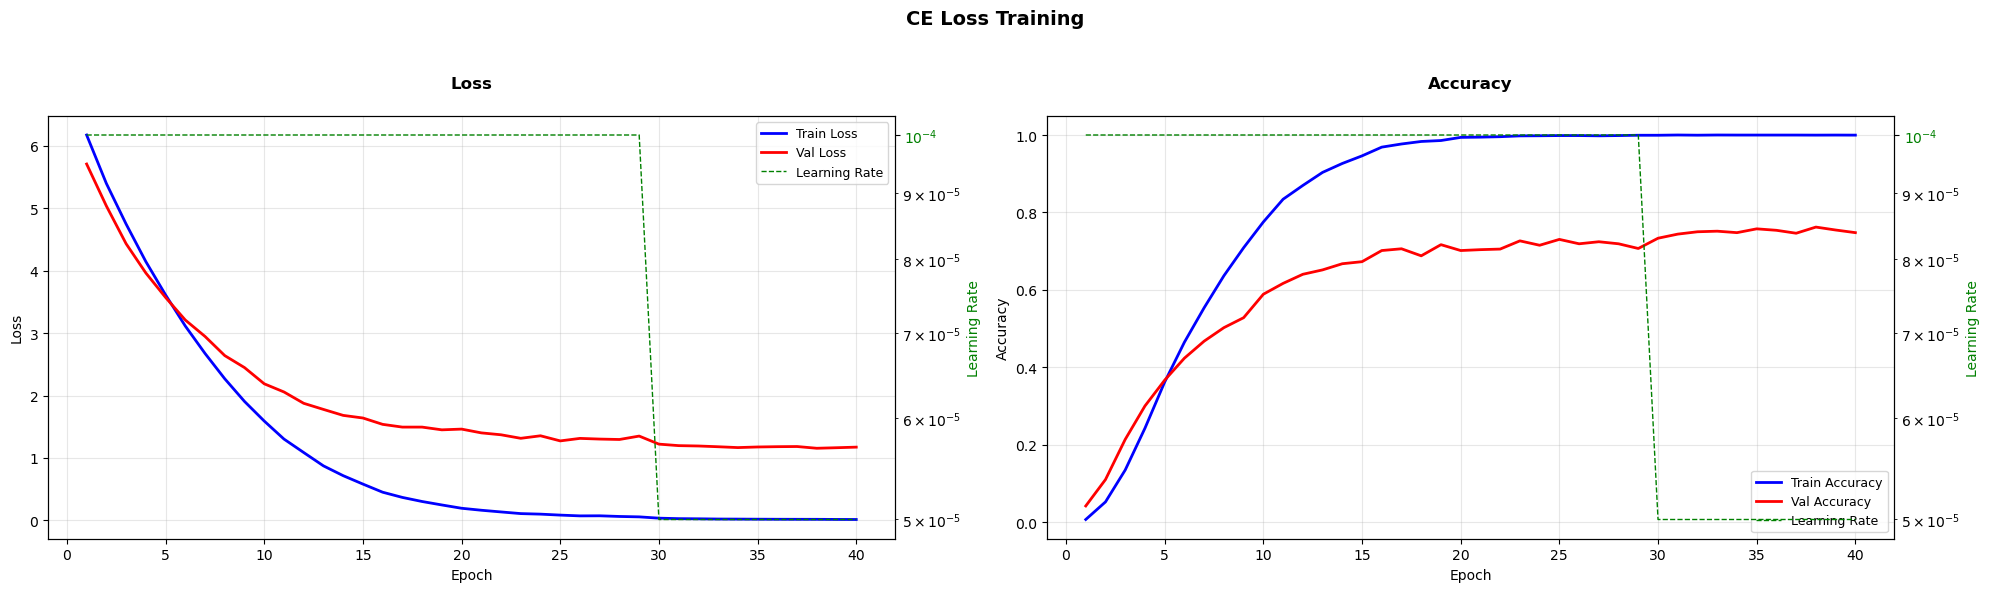

In [178]:
# визуализируем прогресс обучения
plot_training_history(history=history_ce, title='CE Loss Training')

Тестируем обученную модель на тестовом наборе

In [179]:
# загружаем лучшую модель
best_model_ce_path = history_ce['best_model_path']
best_model_ce = FRModel(num_classes=num_classes).to(DEVICE) # создаем модель
checkpoint = torch.load(best_model_ce_path, map_location=DEVICE) # загружаем состояние модели
best_model_ce.load_state_dict(checkpoint['model_state_dict']) # загружаем веса модели
best_model_ce.eval()

# тестируем модель на тестовом датасете
test_result_ce = test_model(
        model=best_model_ce,
        test_loader=test_loader,
        device=DEVICE,
        is_arcface=False
    )
print(f"Лучшие веса модели {history_ce['model_name']} загружены из файла {best_model_ce_path}")
print("Достигнутые метрики:")
print(f"\t- val accuracy: {history_ce['best_val_acc']:.4f}")
print(f"\t- test accuracy: {test_result_ce['accuracy']:.4f}")
print(f"\t- precision: {test_result_ce['precision']:.4f}")
print(f"\t- recall: {test_result_ce['recall']:.4f}")
print(f"\t- F1: {test_result_ce['f1']:.4f}")

Тестирование: 100%|██████████| 42/42 [00:02<00:00, 20.38it/s]

Лучшие веса модели model_fr_ce загружены из файла checkpoints/model_fr_ce_20260125_231417_epoch_38_val_0.7621.pth
Достигнутые метрики:
	- val accuracy: 0.7621
	- test accuracy: 0.7455
	- precision: 0.7914
	- recall: 0.7455
	- F1: 0.7398


In [290]:
# сохраним историю обучения модели в файл одноименный с лучшей моделью
base_name, _ = os.path.splitext(best_model_ce_path)
filename_history_ce = base_name + '.pkl'
with open(filename_history_ce, 'wb') as f:
    pickle.dump(history_ce, f)
print(f"История обучения модели {history_ce['model_name']} сохранена в файл {filename_history_ce}")

История обучения модели model_fr_ce сохранена в файл checkpoints/model_fr_ce_20260125_231417_epoch_38_val_0.7621.pkl


### Модель ResNet18 + ArcFace loss

In [ ]:
class ArcFaceLoss(nn.Module):
    """
    Additive Angular Margin Loss для распознавания лиц
    """
    
    def __init__(self, in_features, out_features, s=40.0, m=0.57): # параметры s и m подобраны экспериментально
        """
        Args:
            in_features: размерность эмбеддингов
            out_features: количество классов
            s: масштабирующий коэффициент
            m: угловой отступ (margin)
        """
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        
        # веса классификатора (центры классов)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)  # инициализация весов
        
        # предвычисленные значения для эффективности
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)  # порог для обрезки
        self.mm = math.sin(math.pi - m) * m  # корректировка для обрезки
    

    def forward(self, inputs, labels):
        """
        Args:
            inputs: нормированные эмбеддинги [batch_size, in_features]
            labels: метки классов [batch_size]
        """
        # нормализация весов классификатора
        cosine = F.linear(F.normalize(inputs), F.normalize(self.weight))
        
        # получаем синус зная косинус
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # угловой отступ: cos(theta + m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        # обрезка для стабильности обучения
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # one-hot кодирование меток
        one_hot = torch.zeros(cosine.size(), device=inputs.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        
        # отступ только к целевому классу
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # масштабирование
        
        return output
    


class FRModel_ArcFace(nn.Module):
    """
    ResNet18 + ArcFace для распознавания лиц
    """
    
    def __init__(self, num_classes, embedding_size=512):
        super(FRModel_ArcFace, self).__init__()
        
        # базовая модель - ResNet18 без последнего слоя
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # удаляем fc
        
        # создаем слой для получения эмбеддингов (нормированных)
        self.embedding_layer = nn.Sequential(
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        # ArcFace слой
        self.arcface = ArcFaceLoss(embedding_size, num_classes)
    

    def forward(self, x, labels=None):
        """
        Args:
            x: входные изображения [batch_size, 3, 224, 224]
            labels: метки классов [batch_size] (требуются для обучения)
        """
        # получаем признаки
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        
        # получаем эмбеддинги
        embeddings = self.embedding_layer(x)
        
        if labels is not None:
            # для обучения: возвращаем логиты с ArcFace
            return self.arcface(embeddings, labels), embeddings
        else:
            # для инференса: возвращаем только эмбеддинги
            return embeddings

### Обучение модели ResNet+ArcFace loss

In [269]:
embedding_size=1024 # начинал с embedding_size=512, но в итоге с 1024 работает лучше

# инициализация модели ArcFace
model_fr_arcface = FRModel_ArcFace(num_classes=num_classes, embedding_size=embedding_size).to(DEVICE) 

# Функция потерь и оптимизатор
criterion_fr_arcface = nn.CrossEntropyLoss()  # используем CE для финальных логитов, а ArcFace - часть архитектуры модели, а не лосс!
optimizer_fr_arcface = optim.AdamW(
    list(model_fr_arcface.backbone.parameters()) + 
    list(model_fr_arcface.embedding_layer.parameters()) + 
    list(model_fr_arcface.arcface.parameters()),
    lr=1e-4,
    weight_decay=5e-4
)

# Scheduler
scheduler_fr_arcface = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fr_arcface, mode='max', factor=0.5, patience=3, verbose=True)

# История обучения (аналогично CE loss)
history_arcface = {
    'train_losses': [],
    'val_losses': [],
    'train_accs': [],
    'val_accs': [],
    'current_lr': []
}

In [ ]:
# обучение модели с ArcFace loss

num_epochs = 40

start_epoch = len(history_arcface['train_losses'])


# Обучение
history_arcface = train_model(
    model=model_fr_arcface,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_fr_arcface,
    optimizer=optimizer_fr_arcface,
    scheduler=scheduler_fr_arcface,
    device=DEVICE,
    num_epochs=num_epochs,
    start_epoch=start_epoch,
    history=history_arcface,
    is_arcface=True,
    checkpoint_dir=dir_checkpoints,
    model_name='arcface_model'
)

Эпоха 1/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:18<00:00, 10.57it/s, loss=27.1215, acc=0.0000, lr=0.000100]
Эпоха 1/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:01<00:00, 27.78it/s, loss=5.1133, acc=0.0000]
Эпоха 2/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:18<00:00, 10.47it/s, loss=25.0582, acc=0.0000, lr=0.000100]
Эпоха 2/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:01<00:00, 25.51it/s, loss=3.6607, acc=0.2500]
Эпоха 3/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:18<00:00, 10.24it/s, loss=25.1767, acc=0.0000, lr=0.000100]
Эпоха 3/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:01<00:00, 25.41it/s, loss=2.2194, acc=0.6250]
Эпоха 4/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:18<00:00, 10.18it/s, loss=22.9780, acc=0.0000, lr=0.000100]
Эпоха 4/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:01<00:00, 22.15it/s, loss=1.6593, acc=0.7500]
Эпох

Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162619_epoch_13_val_0.7136.pth. Val Acc: 0.7136


Эпоха 14/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.78it/s, loss=8.5705, acc=0.2500, lr=0.000100] 
Эпоха 14/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.72it/s, loss=1.0560, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162641_epoch_14_val_0.7212.pth. Val Acc: 0.7212


Эпоха 15/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.74it/s, loss=7.6233, acc=0.1875, lr=0.000100] 
Эпоха 15/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 17.02it/s, loss=1.1261, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162704_epoch_15_val_0.7250.pth. Val Acc: 0.7250


Эпоха 16/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.66it/s, loss=10.0635, acc=0.1250, lr=0.000100]
Эпоха 16/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.54it/s, loss=1.4071, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162727_epoch_16_val_0.7394.pth. Val Acc: 0.7394


Эпоха 17/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.66it/s, loss=8.2695, acc=0.1250, lr=0.000100]
Эпоха 17/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.11it/s, loss=2.0906, acc=0.7500]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162750_epoch_17_val_0.7462.pth. Val Acc: 0.7462


Эпоха 18/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.67it/s, loss=4.7206, acc=0.3750, lr=0.000100]
Эпоха 18/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.14it/s, loss=1.6992, acc=0.8750]
Эпоха 19/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.83it/s, loss=3.4888, acc=0.5000, lr=0.000100]
Эпоха 19/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.02it/s, loss=1.6776, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162835_epoch_19_val_0.7538.pth. Val Acc: 0.7538


Эпоха 20/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.47it/s, loss=5.3426, acc=0.1875, lr=0.000100]
Эпоха 20/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 16.08it/s, loss=1.3813, acc=0.7500]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162858_epoch_20_val_0.7576.pth. Val Acc: 0.7576


Эпоха 21/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.67it/s, loss=5.2121, acc=0.3750, lr=0.000100]
Эпоха 21/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 17.29it/s, loss=2.0207, acc=0.8750]
Эпоха 22/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.66it/s, loss=4.4815, acc=0.4375, lr=0.000100]
Эпоха 22/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 17.62it/s, loss=1.6766, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_162944_epoch_22_val_0.7614.pth. Val Acc: 0.7614


Эпоха 23/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.75it/s, loss=3.3770, acc=0.3750, lr=0.000100]
Эпоха 23/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.85it/s, loss=1.7383, acc=0.8750]
Эпоха 24/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.70it/s, loss=3.4531, acc=0.4375, lr=0.000100]
Эпоха 24/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.25it/s, loss=1.1598, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163029_epoch_24_val_0.7636.pth. Val Acc: 0.7636


Эпоха 25/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.84it/s, loss=2.1003, acc=0.6875, lr=0.000100]
Эпоха 25/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.49it/s, loss=1.3408, acc=0.8750]
Эпоха 26/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:20<00:00,  9.65it/s, loss=1.1042, acc=0.6250, lr=0.000100]
Эпоха 26/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.45it/s, loss=1.5133, acc=0.8750]
Эпоха 27/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.74it/s, loss=1.9046, acc=0.5625, lr=0.000100]
Эпоха 27/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.53it/s, loss=1.8600, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163137_epoch_27_val_0.7667.pth. Val Acc: 0.7667


Эпоха 28/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.83it/s, loss=0.9959, acc=0.8125, lr=0.000100]
Эпоха 28/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.53it/s, loss=0.8157, acc=0.8750]
Эпоха 29/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.70it/s, loss=0.4829, acc=0.8750, lr=0.000100]
Эпоха 29/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.23it/s, loss=2.0250, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163222_epoch_29_val_0.7674.pth. Val Acc: 0.7674


Эпоха 30/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.86it/s, loss=1.4804, acc=0.7500, lr=0.000100]
Эпоха 30/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 17.65it/s, loss=1.2147, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163244_epoch_30_val_0.7697.pth. Val Acc: 0.7697


Эпоха 31/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.77it/s, loss=1.0513, acc=0.7500, lr=0.000100]
Эпоха 31/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.45it/s, loss=1.7557, acc=0.8750]
Эпоха 32/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.84it/s, loss=0.8771, acc=0.8125, lr=0.000100]
Эпоха 32/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.37it/s, loss=1.6960, acc=0.8750]
Эпоха 33/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.77it/s, loss=0.6129, acc=0.8750, lr=0.000100]
Эпоха 33/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.55it/s, loss=1.0074, acc=0.8750]
Эпоха 34/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.78it/s, loss=0.5004, acc=0.8750, lr=0.000100]
Эпоха 34/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 17.84it/s, loss=1.4706, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163436_epoch_35_val_0.7773.pth. Val Acc: 0.7773


Эпоха 36/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.81it/s, loss=0.5364, acc=0.9375, lr=0.000050]
Эпоха 36/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.56it/s, loss=1.2867, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163459_epoch_36_val_0.7833.pth. Val Acc: 0.7833


Эпоха 37/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.65it/s, loss=0.2841, acc=0.8750, lr=0.000050]
Эпоха 37/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.38it/s, loss=1.0900, acc=0.8750]
Эпоха 38/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.80it/s, loss=0.3555, acc=0.8750, lr=0.000050]
Эпоха 38/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.11it/s, loss=1.1185, acc=0.8750]


Новая лучшая модель сохранена в checkpoints_arcface/arcface_model_20260126_163544_epoch_38_val_0.7848.pth. Val Acc: 0.7848


Эпоха 39/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.81it/s, loss=0.4190, acc=0.8125, lr=0.000050]
Эпоха 39/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 18.70it/s, loss=1.6375, acc=0.8750]
Эпоха 40/40 | Обучение: 100%|██████████████████████████████| 193/193 [00:19<00:00,  9.69it/s, loss=0.0745, acc=1.0000, lr=0.000050]
Эпоха 40/40 | Валидация: 100%|██████████████████████████████| 42/42 [00:02<00:00, 19.28it/s, loss=1.3375, acc=0.8750]



Обучение завершено! Финальный чекпоинт сохранен в checkpoints_arcface/arcface_model_final_20260126_163628.pth


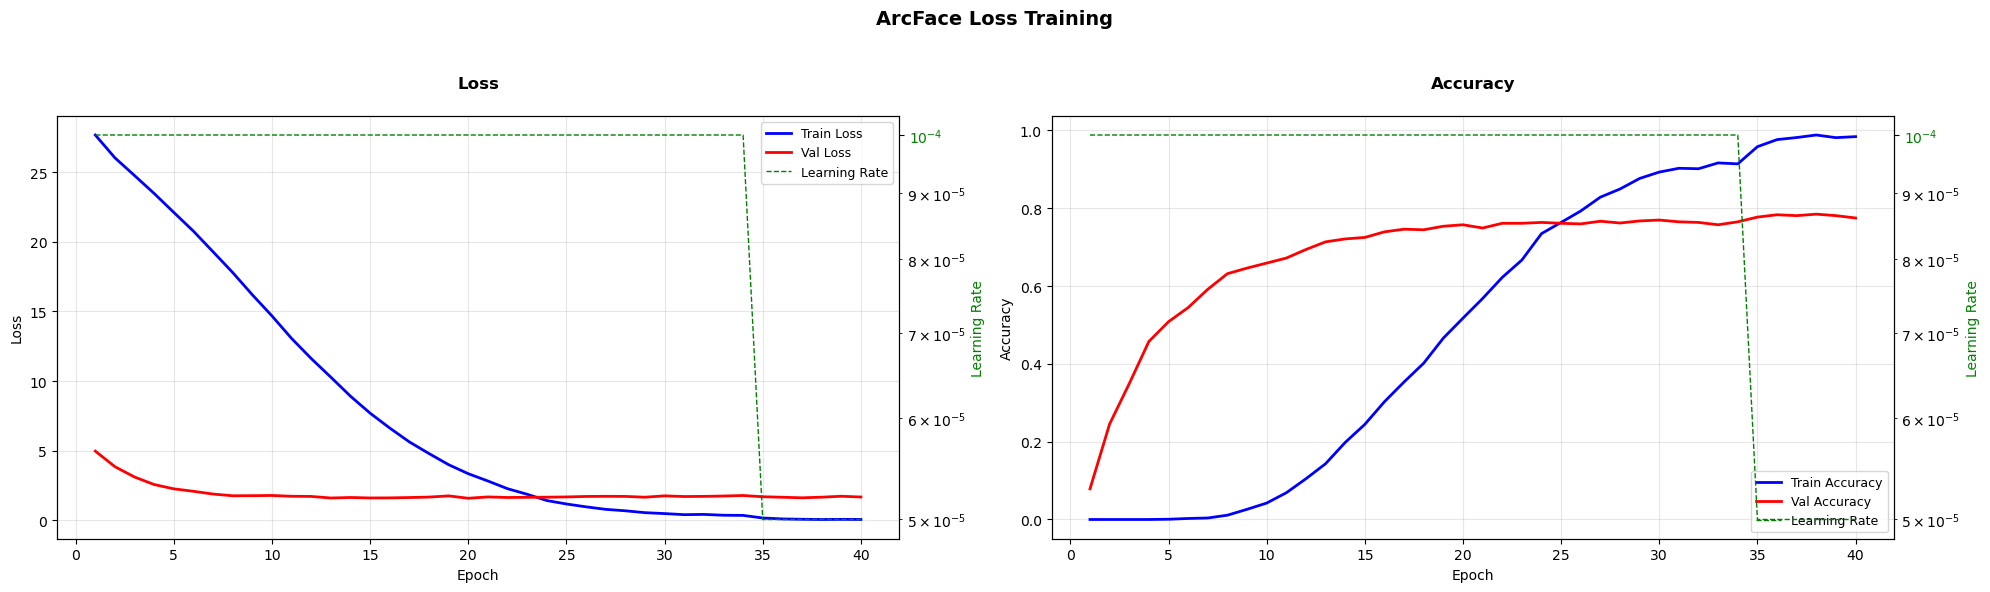

In [271]:
# визуализируем прогресс обучения
plot_training_history(history=history_arcface, title='ArcFace Loss Training')

In [272]:
# загружаем лучшую модель
best_model_arcface_path = history_arcface['best_model_path']
best_model_arcface = FRModel_ArcFace(num_classes=num_classes, embedding_size=embedding_size).to(DEVICE) # создаем модель
checkpoint = torch.load(best_model_arcface_path, map_location=DEVICE) # загружаем состояние модели
best_model_arcface.load_state_dict(checkpoint['model_state_dict']) # загружаем веса модели
best_model_arcface.eval()

# тестируем модель на тестовом датасете
test_result_arcface = test_model(
        model=best_model_arcface,
        test_loader=test_loader,
        device=DEVICE,
        is_arcface=True
    )
print(f"Лучшие веса модели {history_arcface['model_name']} загружены из файла {best_model_arcface_path}")
print("Достигнутые метрики:")
print(f"\t- val accuracy: {history_arcface['best_val_acc']:.4f}")
print(f"\t- test accuracy: {test_result_arcface['accuracy']:.4f}")
print(f"\t- precision: {test_result_arcface['precision']:.4f}")
print(f"\t- recall: {test_result_arcface['recall']:.4f}")
print(f"\t- F1: {test_result_arcface['f1']:.4f}")

Тестирование: 100%|██████████| 42/42 [00:01<00:00, 25.67it/s]

Лучшие веса модели arcface_model загружены из файла checkpoints_arcface/arcface_model_20260126_163544_epoch_38_val_0.7848.pth
Достигнутые метрики:
	- val accuracy: 0.7848
	- test accuracy: 0.7879
	- precision: 0.8186
	- recall: 0.7879
	- F1: 0.7797


In [291]:
# сохраним историю обучения модели в файл одноименный с лучшей моделью
base_name, _ = os.path.splitext(best_model_arcface_path)
filename_history_arcface = base_name + '.pkl'
with open(filename_history_arcface, 'wb') as f:
    pickle.dump(history_arcface, f)
print(f"История обучения модели {history_arcface['model_name']} сохранена в файл {filename_history_arcface}")

История обучения модели arcface_model сохранена в файл checkpoints_arcface/arcface_model_20260126_163544_epoch_38_val_0.7848.pkl


### Сравнение моделей

In [242]:
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

def visualize_arcface_behavior(model, loader, device, is_arcface=True, num_samples=100):
    """
    Визуализация поведения модели на примерах
    """
    model.eval()
    embeddings_list = []
    labels_list = []
    images_list = []
    predictions_list = []
    
    with torch.no_grad():
        for images, labels in loader:
            if len(embeddings_list) >= num_samples:
                break
            
            images, labels = images.to(device), labels.to(device)
            
            if is_arcface:
                embeddings = model(images)
            else:
                # Для CE loss получаем фичи из penultimate layer
                x = model.model.conv1(images)
                x = model.model.bn1(x)
                x = model.model.relu(x)
                x = model.model.maxpool(x)
                x = model.model.layer1(x)
                x = model.model.layer2(x)
                x = model.model.layer3(x)
                x = model.model.layer4(x)
                x = model.model.avgpool(x)
                embeddings = torch.flatten(x, 1)
            
            # нормализуем эмбеддинги для визуализации
            embeddings = F.normalize(embeddings, p=2, dim=1)
            
            # получаем предсказания
            if is_arcface:
                weights = F.normalize(model.arcface.weight)
                logits = F.linear(embeddings, weights) * model.arcface.s
                _, preds = torch.max(logits, 1)
            else:
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
            
            embeddings_list.append(embeddings.cpu().detach().numpy())
            labels_list.append(labels.cpu().detach().numpy())
            predictions_list.append(preds.cpu().detach().numpy())
            
            # первые 5 изображений для визуализации
            if len(images_list) < 5:
                images_list.append(images[:5].cpu().detach())
    
    # объединяем данные
    embeddings = np.vstack(embeddings_list)
    labels = np.concatenate(labels_list)
    predictions = np.concatenate(predictions_list)
    images = torch.cat(images_list, dim=0) if images_list else None
    
    plt.figure(figsize=(10, 4))    
    # t-SNE по классам
    plt.subplot(1, 2, 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings[:50])
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels[:50], cmap='tab20', alpha=0.8, s=50)
    plt.colorbar(scatter, label='Class ID')
    plt.title('t-SNE эмбеддингов (по классам)', fontsize=12, fontweight='bold')
    plt.xlabel('t-SNE компонент 1')
    plt.ylabel('t-SNE компонент 2')
    plt.grid(alpha=0.3)
    
    # t-SNE по точности предсказаний
    plt.subplot(1, 2, 2)
    is_correct = (predictions == labels)[:50]
    colors = ['green' if correct else 'red' for correct in is_correct]
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               c=colors, alpha=0.8, s=50, edgecolors='k')
    plt.title('t-SNE эмбеддингов (правильность)', fontsize=12, fontweight='bold')
    plt.xlabel('t-SNE компонент 1')
    plt.ylabel('t-SNE компонент 2')
    plt.grid(alpha=0.3)
    
    # легенда
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Верно'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Ошибка')
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # распределение косинусных расстояний
    if is_arcface and hasattr(model, 'arcface') and hasattr(model.arcface, 'weight'):
        # веса классов
        class_weights = F.normalize(model.arcface.weight, dim=1).cpu().detach().numpy()
        class_labels = np.arange(class_weights.shape[0])
        # генерируем случайные пары классов
        np.random.seed(42)
        idx1 = np.random.choice(len(class_labels), 200)
        idx2 = np.random.choice(len(class_labels), 200)
        
        cosine_dists = []
        for i1, i2 in zip(idx1, idx2):
            if i1 != i2:
                cos_dist = np.dot(class_weights[i1], class_weights[i2])
                cosine_dists.append(cos_dist)
        
        if cosine_dists:
            plt.figure(figsize=(6, 4))
            
            plt.hist(cosine_dists, bins=30, alpha=0.7, color='blue', edgecolor='black')
            plt.title('Распределение косинусных расстояний между классами', fontsize=14, fontweight='bold')
            plt.xlabel('Косинусное расстояние', fontsize=12)
            plt.ylabel('Частота', fontsize=12)
            plt.grid(alpha=0.3)
            plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Нулевая граница')
            plt.legend()
            
            # Добавляем статистику
            mean_dist = np.mean(cosine_dists)
            plt.text(0.05, 0.95, f'Среднее: {mean_dist:.3f}', 
                    transform=plt.gca().transAxes, fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
    
    print(f"Всего эмбеддингов проанализировано: {len(embeddings)}")
    print(f"Уникальных классов: {len(np.unique(labels))}")
    print(f"Точность на этих данных: {np.mean(predictions == labels):.4f}")
    
    if 'cosine_dists' in locals() and cosine_dists:
        print(f"Среднее косинусное расстояние между классами: {np.mean(cosine_dists):.4f}")
        print(f"Минимальное расстояние: {np.min(cosine_dists):.4f}")
        print(f"Максимальное расстояние: {np.max(cosine_dists):.4f}")


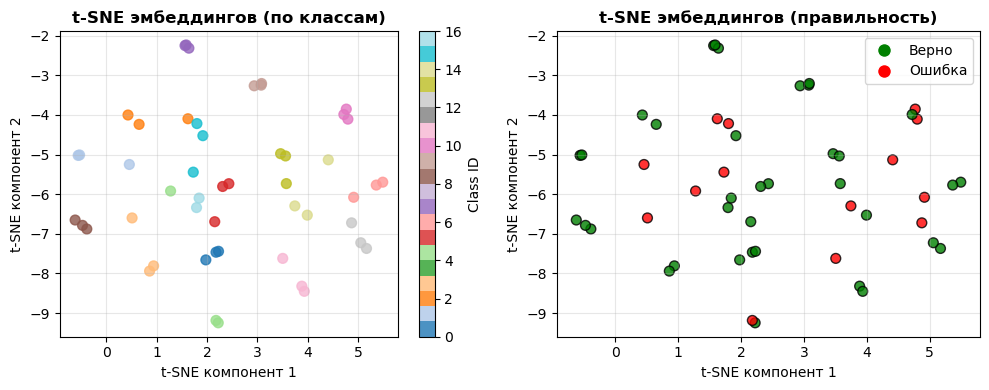

Всего эмбеддингов проанализировано: 1320
Уникальных классов: 440
Точность на этих данных: 0.7477


In [276]:
# визуализируем модель, обученную на CE loss
visualize_arcface_behavior(
    model=model_fr_ce,
    loader=val_loader,
    device=DEVICE,
    is_arcface=False,
    num_samples=100
)

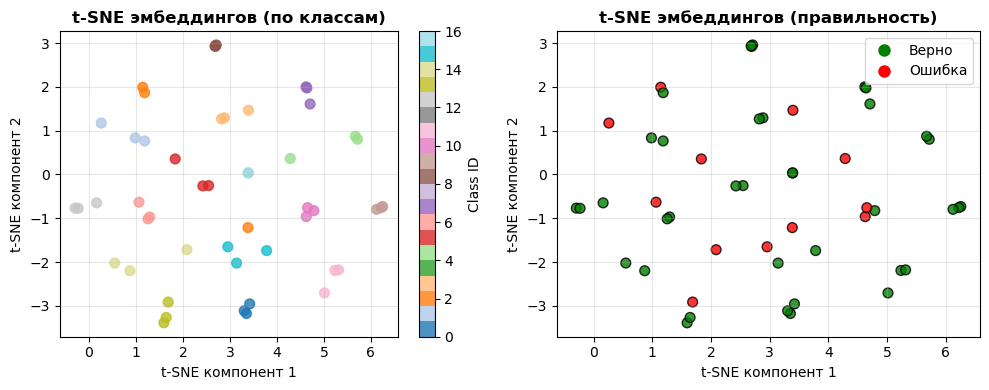

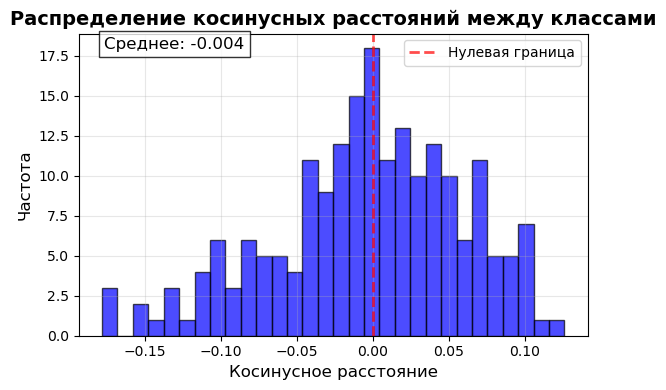

Всего эмбеддингов проанализировано: 1320
Уникальных классов: 440
Точность на этих данных: 0.7750
Среднее косинусное расстояние между классами: -0.0041
Минимальное расстояние: -0.1781
Максимальное расстояние: 0.1259


In [277]:
visualize_arcface_behavior(
    model=model_fr_arcface,
    loader=val_loader,
    device=DEVICE,
    is_arcface=True,
    num_samples=100
)

In [245]:
def visualize_errors(model, loader, class_to_images, device, is_arcface=False, num_errors=3):
    """
    Визуализация ошибок: для каждого неправильно предсказанного изображения
    показывает изображения из предсказанного класса
    
    Args:
        model: обученная модель
        loader: загрузчик данных
        class_to_images: словарь {class_id: [image_paths]}
        device: устройство
        is_arcface: флаг для ArcFace модели
        num_errors: количество ошибок для визуализации
    """
    model.eval()
    errors = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Поиск ошибок"):
            images, labels = images.to(device), labels.to(device)
            
            if is_arcface:
                embeddings = model(images)
                weights = F.normalize(model.arcface.weight)
                logits = F.linear(F.normalize(embeddings), weights) * model.arcface.s
                outputs = logits
            else:
                outputs = model(images)
            
            _, preds = torch.max(outputs.data, 1)
            
            # находим ошибки
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    errors.append({
                        'image': images[i].cpu(),
                        'true_class': labels[i].cpu().item(),
                        'pred_class': preds[i].cpu().item()
                    })
                    if len(errors) >= num_errors*2:  # запас
                        break
            if len(errors) >= num_errors*2:
                break
    
    # собираем уникальные ошибки
    unique_errors = []
    seen_pairs = set()
    for err in errors:
        pair = (err['true_class'], err['pred_class'])
        if pair not in seen_pairs:
            seen_pairs.add(pair)
            unique_errors.append(err)
        if len(unique_errors) >= num_errors:
            break
    
    if not unique_errors:
        print("Ошибок визуализации не найдено!")
        return
    
    plt.figure(figsize=(10, 3*num_errors))
    
    for idx, err in enumerate(unique_errors[:num_errors]):
        true_class = err['true_class']
        pred_class = err['pred_class']
        
        # неверно классифицированное изображение
        plt.subplot(num_errors, 3, idx*3 + 1)
        img = denormalize(err['image']).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {pred_class}", color='red', fontweight='bold')
        plt.axis('off')
        
        # примеры из предсказанного класса
        pred_images = class_to_images.get(pred_class, [])
        if pred_images:
            sample_images = random.sample(pred_images, min(2, len(pred_images)))
            
            for j, img_path in enumerate(sample_images):
                plt.subplot(num_errors, 3, idx*3 + 2 + j)
                img_sample = Image.open(img_path).convert('RGB')
                img_sample = val_transform(img_sample)  # Применяем валидационные трансформации
                img_sample = denormalize(img_sample).permute(1, 2, 0).numpy()
                img_sample = np.clip(img_sample, 0, 1)
                plt.imshow(img_sample)
                plt.title(f"Class {pred_class} sample", color='green')
                plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Анализ ошибок', fontsize=16, fontweight='bold', y=0.99)
    plt.show()

# Вспомогательная функция для денормализации
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Создание словаря class_id -> изображения
def build_class_to_images(metadata_file, images_dir):
    """Создает словарь {class_id: [image_paths]}"""
    metadata = pd.read_csv(metadata_file)
    class_to_images = {}
    
    for class_id, group in metadata.groupby('class_id'):
        image_paths = [os.path.join(images_dir, img_id) for img_id in group['image_id']]
        class_to_images[class_id] = image_paths
    
    return class_to_images


# создаем словарь классов к изображениям
class_to_images = build_class_to_images(
    metadata_file=f'{dir_metadata_fr}/val_metadata.csv',
    images_dir=val_dir
)


Поиск ошибок:   2%|▏         | 1/42 [00:00<00:21,  1.91it/s]


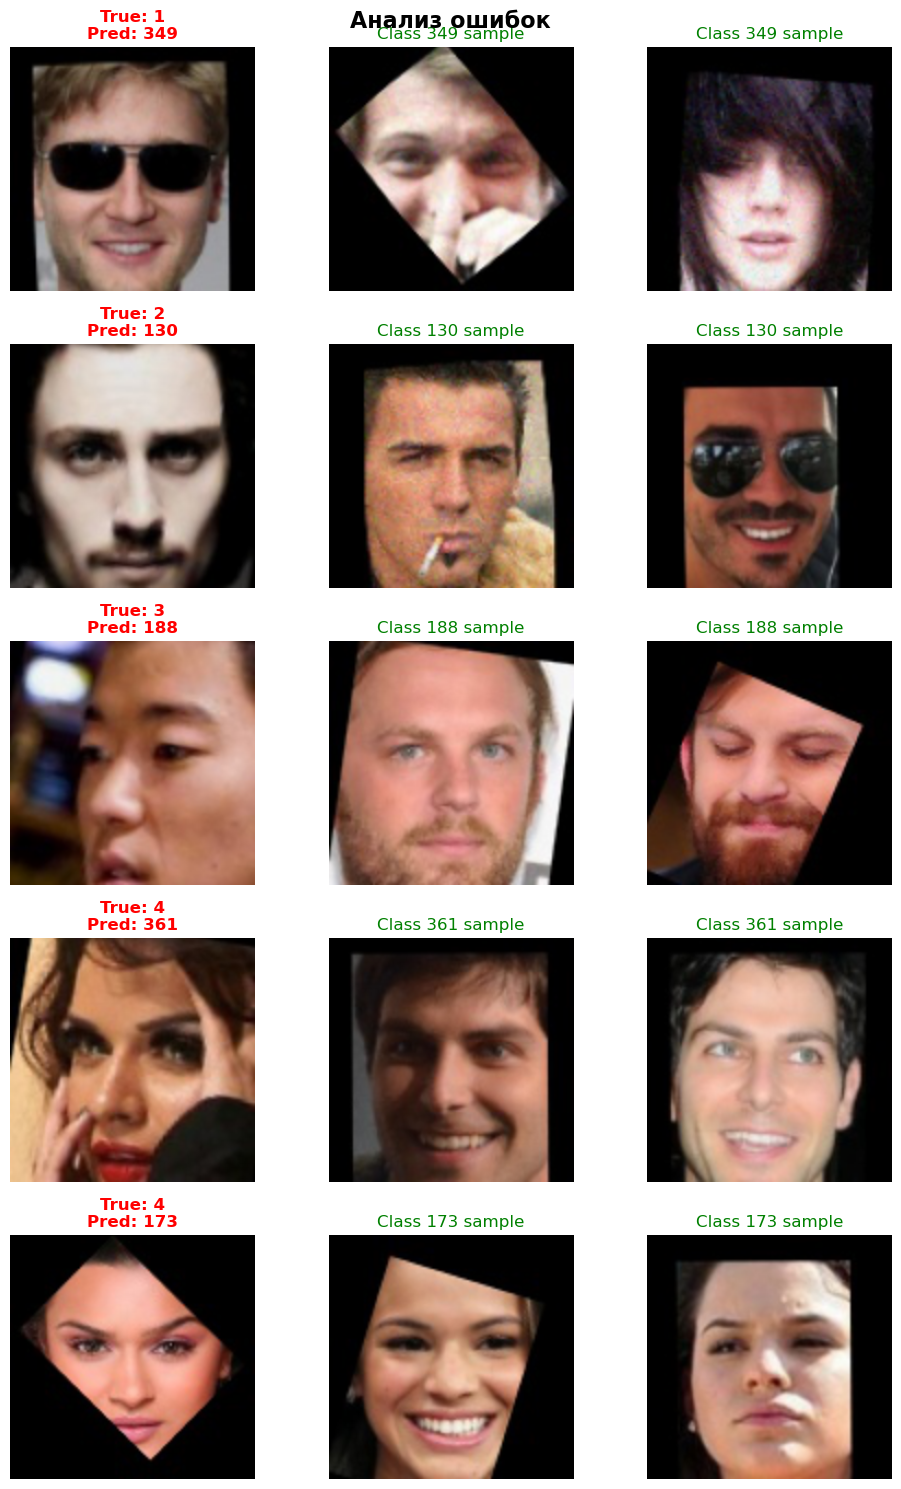

In [246]:
# визуализируем ошибки модели, обученной на CE loss
visualize_errors(
    model=model_fr_ce,
    loader=val_loader,
    class_to_images=class_to_images,
    device=DEVICE,
    is_arcface=False,
    num_errors=5
)

Поиск ошибок:   2%|▏         | 1/42 [00:00<00:19,  2.07it/s]


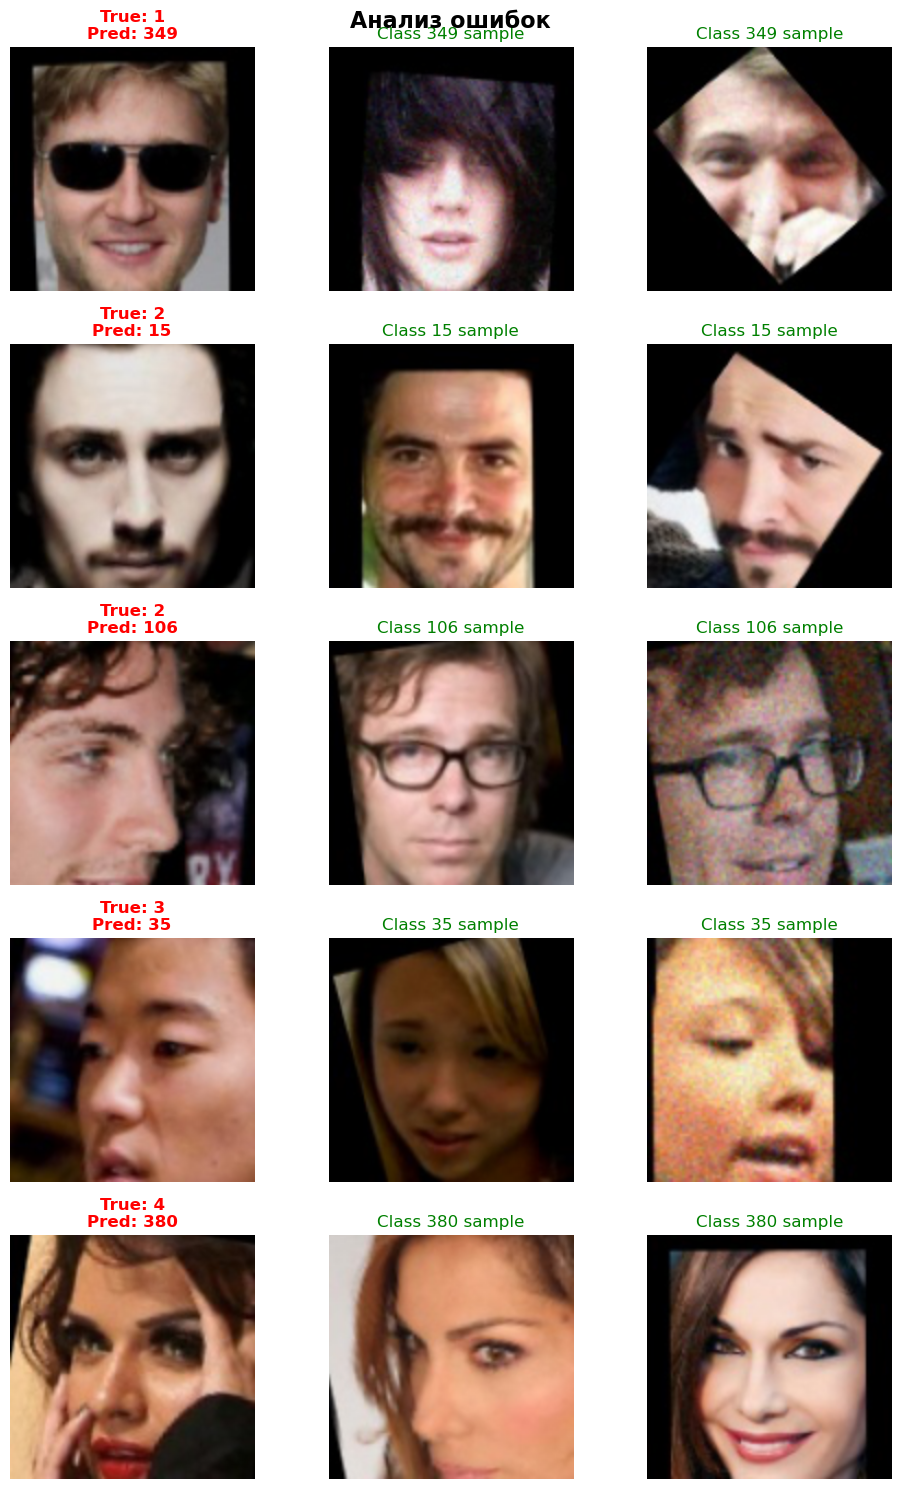

In [278]:
# визуализируем ошибки модели, обученной на ArcFace loss
visualize_errors(
    model=model_fr_arcface,
    loader=val_loader,
    class_to_images=class_to_images,
    device=DEVICE,
    is_arcface=True,
    num_errors=5
)

### Выводы.

Во второй части проекта подготовлен датасет для моделей распознавания лиц с физическим разделением изображений по папкам. Подготовленный датасет содержит 440 персон с выровненными изображениями. Еще 100 персон отложены для реализации дополнительного задания по реализации Identification Rate Metric.

Обучены две модели:

1) Базовая модель с CE loss: точность на тесте 0.7455
2) Модель с ArcFace loss: точность на тесте 0.7879, точность на валидации 0.7924
Параметры ArcFace (m=0.57, s=40.0) и размер эмбеддингов (1024) подобраны экспериментально. 

Модель с ArcFace показала преимущество как в качестве разделения классов, так и в более высоких метриках классификации.

Обе модели ошибаются на лицах в очках, с усами, когда что-то закрывает лицо (руки, волосы), также азиатские лица хуже распознаются, наверное из-за меньшего объема в датасете.

Для дальнейшего улучшения модели распознавания можно использовать более глубокие ResNet34, ResNet50 или попробовать другие архитектуры, например, EfficientNet. Также следует увеличить объем датасета, на котором учатся модели. Также хороший прирост в качестве, на мой взгляд, можно получить поставив четкую цель для системы распознавания лиц - где будет работать, что надо минимизировать ошибки первого или второго рода (у нас все-таки система классификации), от этого будет зависеть техническое задание на подготовку обучающего датасета - выбор необходимых признаков, стратифицированная выборка, выборка количества персон и количества изображений каждой персоны.